In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_path = "/app/output_dir/manual-exp-0"
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_path)

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


### **Генерация модели с финального эксперимента**

- обучение 30 минут
- Best eval loss: 5.2090
- Best eval perplexity: 182.91

**Лучшие гиперпараметры**


- 'batch_size': 3,
- 'gradient_accumulation_steps': 10,
- 'learning_rate': 1e-4,
- 'optimizer': 'adamw_torch_fused',
- 'lr_scheduler': 'cosine',
- 'torch_compile': True,
- 'warmup_steps': 0,

In [2]:
prompt = "Напиши короткий рассказ о искусственном интеллекте:"
inputs = tokenizer(prompt, return_tensors="pt")

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Напиши короткий рассказ о искусственном интеллекте: «Нагущее имя, на котором не всегда не просто в это время, чем вы, чтобы иметь его происхождение. С другой точки зрения и не обязательно, в свою очередь, это было, если в них не больше и в случае, когда мы не будут вписать» (на самом деле, когда только в качестве названия, а в других языках), так как их как, а в различных языках, например, и в виде его правления.

Если-то и тогда, то мы не


**График снижения лосса лучшего рана**

Все графики лоссов экспериментов доступны через mlflow ui.

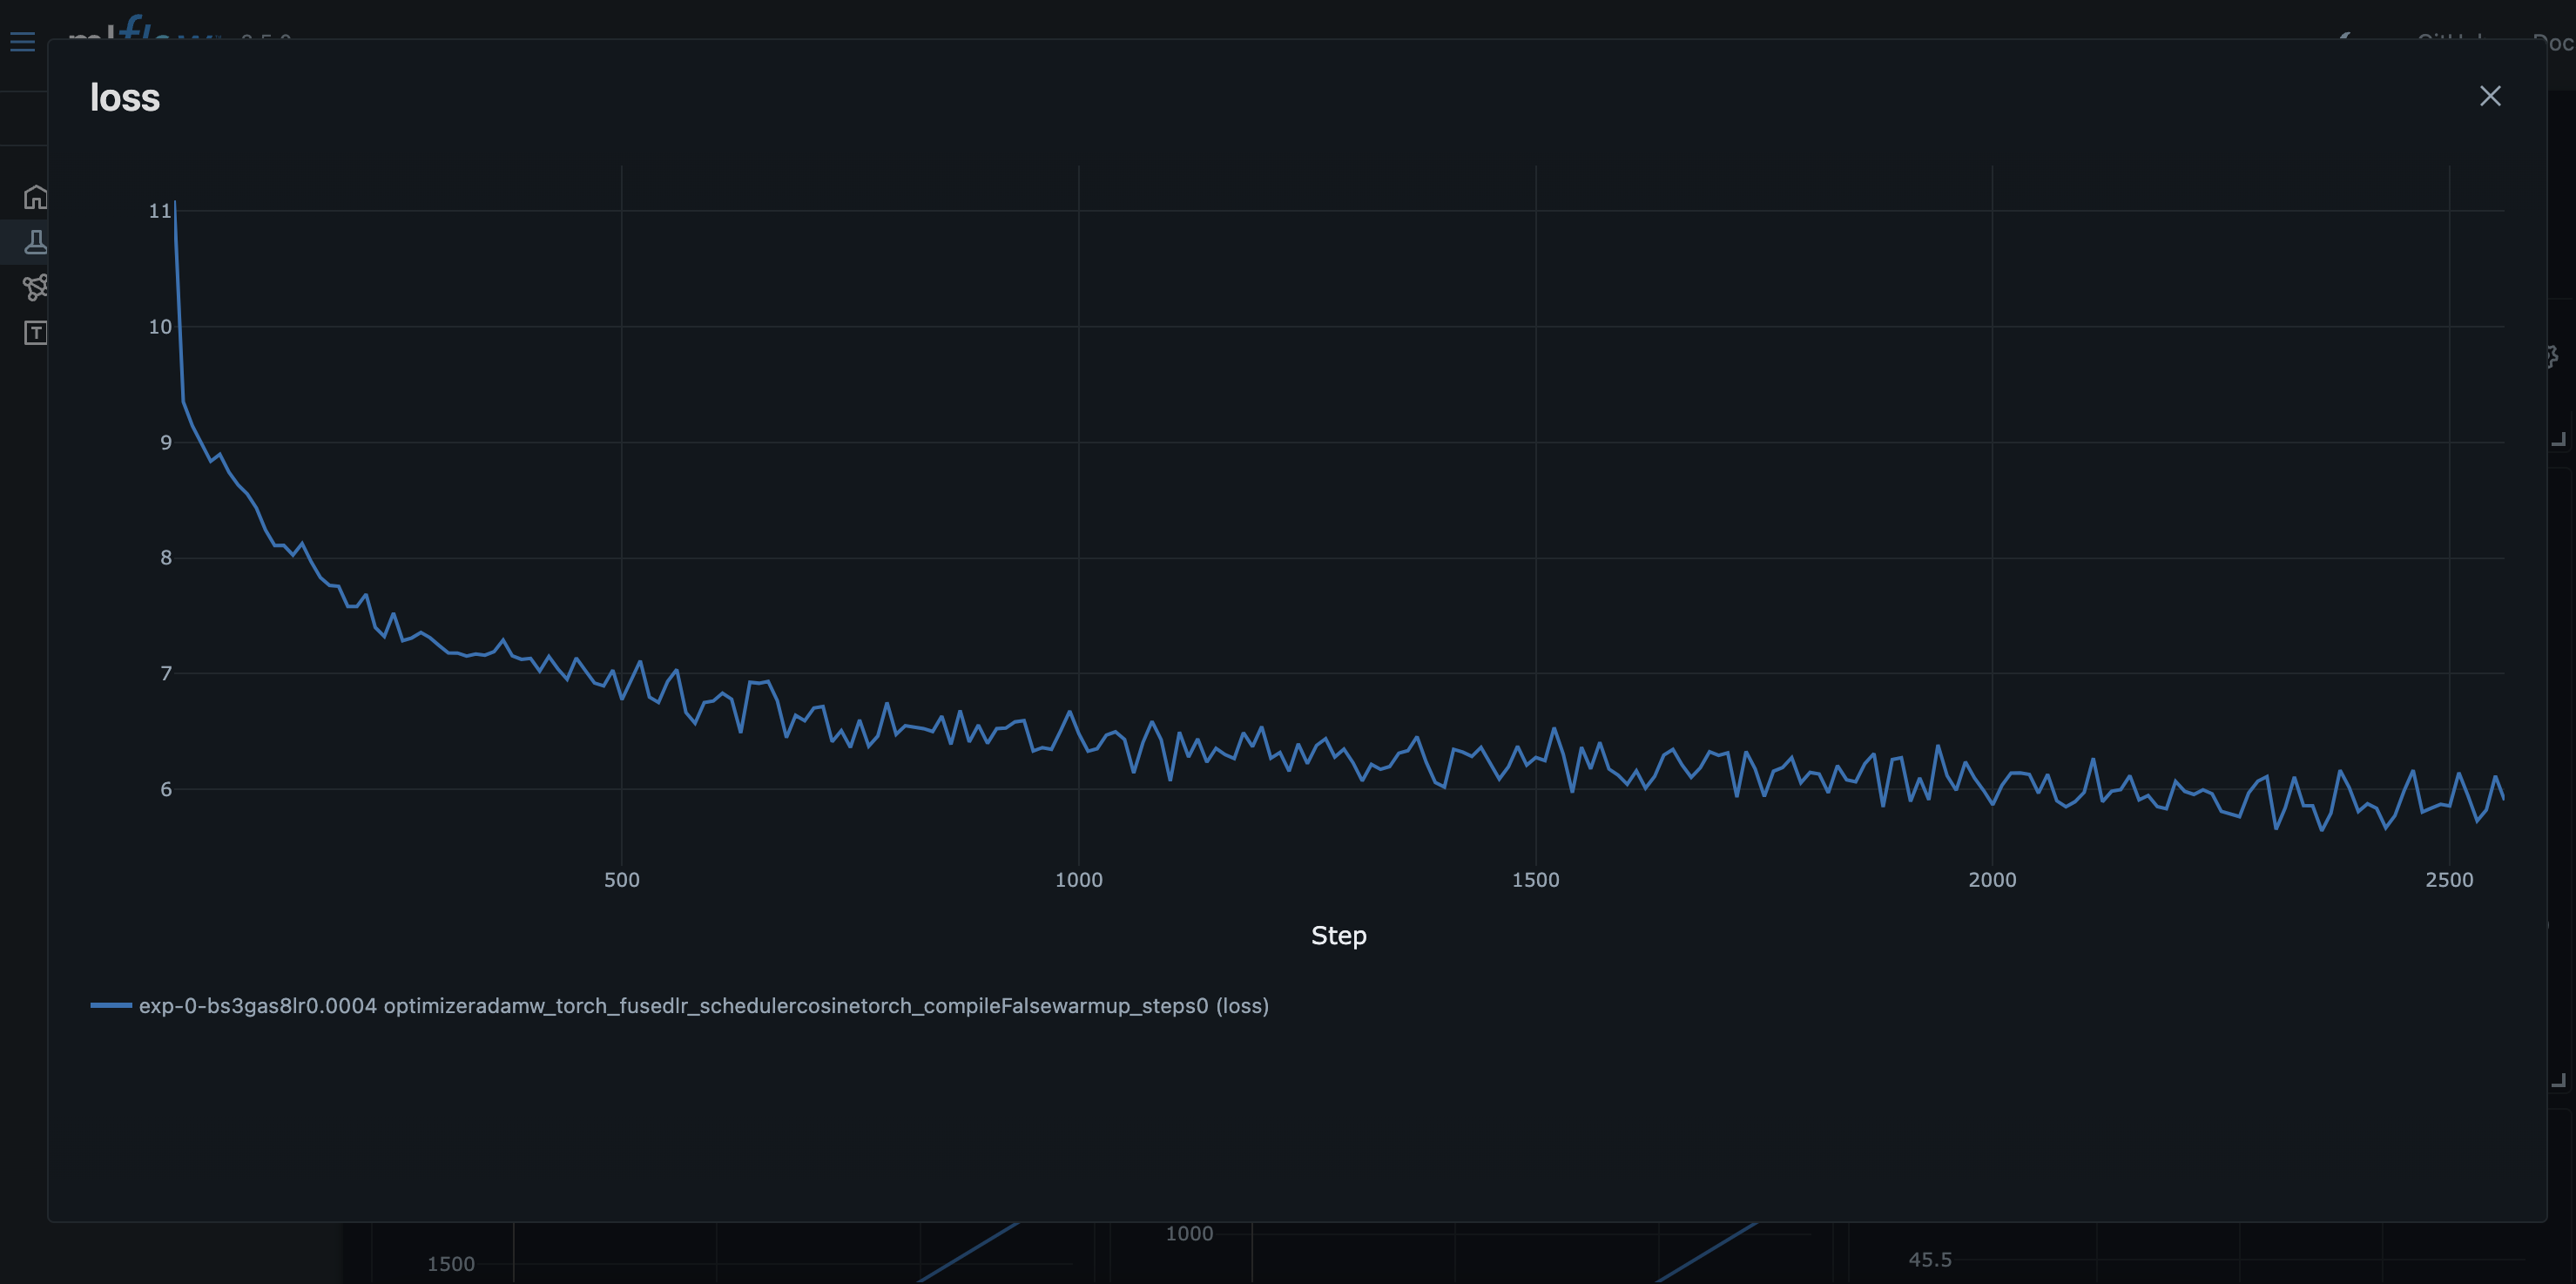

**Выводы и наблюдения из экспериментов**

- С optimizer = adamw_torch_fused лосс сходится быстрее + вычисления быстрее, успеваем пройти большее кол-во шагов за 30 мин
- warmup_steps = 0, не особо влияет на обучение в начале
- с высоким learning_rate (4e-4, 5e-4) лосс в конце слишком волатилен, и не снижается дальше, хотя вначале очень быстро приходит к eval_loss=6
- lr_scheduler = cosine показал себя лучше
- torch_compile = True дает прирост по скорости - с тем же конфигом 1.52it/s против 1.19it/s с torch_compile=False
- batch_size побольше, gradient_accumulation_steps поменьше чтобы было честное вычисление градиента без усреднений. Высокий gradient_accumulation_steps используется только если есть проблемы с памятью. Но у меня получилось так, что при bs=3,gac=10 лучший ран, обратное сошлось чуть хуже
- dataloader_num_workers = 6 - чтобы обучение было быстрее
- 'save_strategy': "no" -- иначе если часто делать eval на сете из 5000 примеров, то слишком много времени уходит